In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image
import io
import time
import math
import imageio
from IPython.display import Image as IPImage
import torch
import torch.nn as nn
import torch.nn.functional as F


## 1. General

The original satellite images were obtained from the GOES-16 Advanced Baseline Imager (ABI), which is publicly available on Google Cloud Storage. The original full-disk images were reprojected using bilinear resampling to generate a local scene image. Because contrails are easier to identify with temporal context, a sequence of images at 10-minute intervals are provided. Each example (record_id) contains exactly one labeled frame. Some key labeling guidance:

- Contrails minst contain at least 10 pixels
- At some time in their life, Contrails must be at least 3x longer than they are wide
- Contrails must either appear suddenly or enter from the sides of the image
- Contrails should be visible in at least two image

Ground truth was determined by (generally) 4+ different labelers annotating each image. Pixels were considered a contrail when >50% of the labelers annotated it as such. Individual annotations (human_individual_masks.npy) as well as the aggregated ground truth annotations (human_pixel_masks.npy) are included in the training data. The validation data only includes the aggregated ground truth annotations.

### 1.1. Files

- <u>train</u> - the training set; each folder represents a record_id and contains the following data:
     - **band_{08-16}.npy**: array with size of H x W x T, where T = n_times_before + n_times_after + 1, representing the number of images in the sequence. There are n_times_before and n_times_after images before and after the labeled frame respectively. In our dataset all examples have n_times_before=4 and n_times_after=3. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found here.
     - **human_individual_masks.npy**: array with size of H x W x 1 x R. Each example is labeled by R individual human labelers. R is not the same for all samples. The labeled masks have value either 0 or 1 and correspond to the (n_times_before+1)-th image in band_{08-16}.npy. They are available only in the training set.
     - **human_pixel_masks.npy**: array with size of H x W x 1 containing the binary ground truth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers.
- <u>validation</u> - the same as the training set, without the individual label annotations; it is permitted to use this as training data if desired
- <u>test</u> - the test set; your objective is to identify contrails found in these records.
- <u>{train|validation}_metadata.json</u> - metadata information for each record; contains the timestamps and the projection parameters to reproduce the satellite images.

#### 1.1.1. Metadata

The metadata contains the information of each *record_id* about it's map coordinates, the reference system and the time stamp.
- **'row_min'**, **'col_min'**:
- **'row_size'**, **'col_size'**:
- **'timestamp'**: The date and the exact timing given in this format YYYY-MM-DD hh:mm:ss
- **'project_wkt'**: The precise information about the map projection and the coordinate system
    - **'PROJCTS**:  projected coordinate reference system
    - **'GEOGCS'**: geograhic coordinate reference system
    - **'DATUM'**: system used to uniquely define all coordinates on Earth. The most common in the World Geodetic System 1984 (WGS 1984) datum, which is commonly used for global mapping and GPS. https://gisgeography.com/wgs84-world-geodetic-system/ 
    - **'SPHEROID**': spheroid used to model Earth's shape. Usually based on WSG84. It takes as arguments (datum, semi-major axis, inverse flattenin, AUTHORITY). The AUTHORITY element usually specifies the EPSG (European Petroleum Survey Group) code for this ellipsoid.
    - **'PRIMEM'**: Specifies the prime meridian and the authority code for this prime meridian.
    - **'UNIT'**: It specifies the unit of measurements of the coordinates, the conversion factor to radians and the authority code for this unit
    - **'PROJECTION'**: Projection method used for transforming the coordinates
    - **'PARAMETER["latitude_of_origin",0]'**: This parameter specifies the latitude at which the map projection's coordinate values are set to zero. In this case, it's the equator (0 degrees latitude).

    - **'PARAMETER["central_meridian",XX]'**: This parameter specifies the central meridian, which is the reference longitude for the Transverse Mercator projection. 

    - **'PARAMETER["scale_factor",0.9996]'**: This parameter defines the scale factor used in the projection. It's a scaling factor applied to adjust distances on the map to match the actual distances on the Earth's surface.

    - **'PARAMETER["false_easting",500000]'**: This parameter specifies the false easting, which is a value added to all x-coordinates (easting) to ensure that they are positive and within a specified range.

    - **'PARAMETER["false_northing",0]'**: This parameter specifies the false northing, which is a value added to all y-coordinates (northing) to ensure that they are positive and within a specified range.
    - **'UNIT'**: This specifies the unit of measurement of the projected coordinates
    - **'AXIS'**: These lines define the orientation of the coordinate axis in the projected system

The following code was ellaborated by Irene to inspect the details of the projection used

In [4]:
def convert_projection_info(s):
    # We obtain the keys or names for each information about the projection
    keys=re.findall(r'\b(?!EPSG)(?!EAST)(?!NORTH)[A-Z]{4,}\b', s)
    keys=[elem.strip() for elem in keys]

    # We obtain the values that correspond to each key
    values=re.split(r'\b(?!EPSG)(?!EAST)(?!NORTH)[A-Z]{4,}\b', s)
    values=[elem.strip() for elem in values]
    values.pop(0)

    # We delete the information regarding AUTHORITY codes
    indexes=[]
    for i in range(len(keys)):
        if keys[i]=='AUTHORITY':
            indexes.append(i)

    for ind in reversed(indexes):
        values.pop(ind)
        keys.pop(ind)
    
    # We rename the keys that appear more than once to differentiate between them
    counter = {}

    for i in range(len(keys)):
        el = keys[i]
        if keys.count(el) > 1:
            if el not in counter:
                counter[el] = 1
            else:
                counter[el] += 1
                keys[i] = f"{el}{counter[el]}"
    
    # We clean the values list
    values2=[]
    for str in values:
        values2.append(str.replace('[', '').replace(']', '').replace('"','').rstrip(','))
    
    values3=[]
    for str in values2:
        values3.append(re.split(',', str))
    return keys, values3

dataset = r'Z:\google research'
train_metadata=pd.read_json(os.path.join(dataset, 'train_metadata.json'))
s=train_metadata['projection_wkt'][0]
keys=convert_projection_info(s)[0]

result=pd.DataFrame(columns=keys)

for i in range(len(train_metadata)):
    values = convert_projection_info(train_metadata['projection_wkt'][i])[1]
    for j in range(len(values)):
        element=values[j]
        for i in range(len(element)):
            string=element[i]
            if all(char.isdigit() for char in string):
                element[i]=float(string)
            
    result.loc[len(result)]=values

result.head()


,PROJCS,GEOGCS,DATUM,SPHEROID,PRIMEM,UNIT,PROJECTION,PARAMETER,PARAMETER2,PARAMETER3,PARAMETER4,PARAMETER5,UNIT2,AXIS,AXIS2
0,[unknown],[unknown],[WGS_1984],"[WGS 84, 6378137.0, 298.257223563]","[Greenwich, 0.0]","[degree, 0.0174532925199433]",[Transverse_Mercator],"[latitude_of_origin, 0.0]","[central_meridian, -51]","[scale_factor, 0.9996]","[false_easting, 500000.0]","[false_northing, 0.0]","[metre, 1.0]","[Easting, EAST]","[Northing, NORTH]"
1,[unknown],[unknown],[WGS_1984],"[WGS 84, 6378137.0, 298.257223563]","[Greenwich, 0.0]","[degree, 0.0174532925199433]",[Transverse_Mercator],"[latitude_of_origin, 0.0]","[central_meridian, -75]","[scale_factor, 0.9996]","[false_easting, 500000.0]","[false_northing, 0.0]","[metre, 1.0]","[Easting, EAST]","[Northing, NORTH]"
2,[unknown],[unknown],[WGS_1984],"[WGS 84, 6378137.0, 298.257223563]","[Greenwich, 0.0]","[degree, 0.0174532925199433]",[Transverse_Mercator],"[latitude_of_origin, 0.0]","[central_meridian, -81]","[scale_factor, 0.9996]","[false_easting, 500000.0]","[false_northing, 0.0]","[metre, 1.0]","[Easting, EAST]","[Northing, NORTH]"
3,[unknown],[unknown],[WGS_1984],"[WGS 84, 6378137.0, 298.257223563]","[Greenwich, 0.0]","[degree, 0.0174532925199433]",[Transverse_Mercator],"[latitude_of_origin, 0.0]","[central_meridian, -93]","[scale_factor, 0.9996]","[false_easting, 500000.0]","[false_northing, 0.0]","[metre, 1.0]","[Easting, EAST]","[Northing, NORTH]"
4,[unknown],[unknown],[WGS_1984],"[WGS 84, 6378137.0, 298.257223563]","[Greenwich, 0.0]","[degree, 0.0174532925199433]",[Transverse_Mercator],"[latitude_of_origin, 0.0]","[central_meridian, -87]","[scale_factor, 0.9996]","[false_easting, 500000.0]","[false_northing, 0.0]","[metre, 1.0]","[Easting, EAST]","[Northing, NORTH]"


### 1.2. Labelling

Fro labelling they wanted to detect contrails throughout both day and night, so they showed imagery to human labelers in an “ash” false color scheme that combined three longwave GOES-16 brightness temperatures. The red, blue and green channels are represented by the 12µm, difference between 12µm and 11µm, and difference between 11µm and 8µm respectively. This color scheme was chosen to help identify contrails by highlighting iceclouds as darker colors.

- Red: 12µm
- Blue: 12µm - 11 µm
- Green: 11µm - 8µm

Each image patch in the dataset corresponds to an approximately 500 × 500 km region and was reprojected to the Universal Transverse Mercator (UTM) coordinate system (with the zone decided by the northwest corner of the region) using bilinear resampling. Labelers were shown image patches with size of 281×281. As the labels near the boundary are often noisy due to the lack of spatial context, they center-cropped to 256×256 pixels on the images and contrail masks for training and evaluation.

Since the temporal context is important for recognizing contrails, labelers were shown 5 images (50 minutes) before and 2 images (20 minutes) after the image being labeled. An example image sequence of contrail evolution shows how contrails appear spontaneously and spread out over time, while natural cirrus often occur for a longer time. and may get sharper over time instead of spreading out. The advected flight density was also shown to the labelers to assist labeling. It was generated from FlightAware flight data and was advected using the same method as for screening (ECMWF ERA5 wind vector data, with the Runge-Kutta method). The advected flight density of flights which are older (at the time the image was taken) was spread to reflect how uncertainty in the wind vector data makes it less certain about where a contrail will ultimately advect to. Labelers were asked to still label the contrails if flights are not shown in the flight density only when they are very confident. 

## 2. Dataset loading

In [3]:
dataset = r'Z:\google research'
train = os.path.join(dataset, 'train')
test = os.path.join(dataset, 'test')
validation = os.path.join(dataset, 'validation')

In [4]:
num_train=len(os.listdir(train))
num_test=len(os.listdir(test))
num_val=len(os.listdir(validation))
print(f'There are {num_train} scenes in the training set')
print(f'There are {num_test} scenes in the test set')
print(f'There are {num_val} scenes in the validation set')

There are 20529 scenes in the training set
There are 2 scenes in the test set
There are 1857 scenes in the validation set


In [5]:
train_files=[]
test_files=[]
val_files=[]
for im in os.listdir(train):
    train_files.append(os.path.join(train,im))
for im in os.listdir(test):
    test_files.append(os.path.join(test,im))
for im in os.listdir(validation):
    val_files.append(os.path.join(validation,im))

We can check the dimensions of the files to check they match the description in the dataset

In [6]:
scene = train_files[0]

sc_human_individual_labels=np.load(os.path.join(scene,'human_individual_masks.npy'))
sc_ground_truth=np.load(os.path.join(scene,'human_pixel_masks.npy'))

sc_band08=np.load(os.path.join(scene,'band_08.npy'))
sc_band09=np.load(os.path.join(scene,'band_09.npy'))
sc_band10=np.load(os.path.join(scene,'band_10.npy'))
sc_band11=np.load(os.path.join(scene,'band_11.npy'))
sc_band12=np.load(os.path.join(scene,'band_12.npy'))
sc_band13=np.load(os.path.join(scene,'band_13.npy'))
sc_band14=np.load(os.path.join(scene,'band_14.npy'))
sc_band15=np.load(os.path.join(scene,'band_15.npy'))
sc_band16=np.load(os.path.join(scene,'band_16.npy'))

print('Individual masks: ' + str(sc_human_individual_labels.shape))
print('Ground truth: ' + str(sc_ground_truth.shape))
print('Scene band: ' + str(sc_band08.shape))

Individual masks: (256, 256, 1, 4)
Ground truth: (256, 256, 1)
Scene band: (256, 256, 8)


## 3. Visualization

### 3.1. Ash colours

The ash colour scheme is made through the following combination of the bands according to the main paper:

- Red= 12µm - 11 µm -> Band 15 - Band 14
- Blue= 11µm -> Band 14
- Green= 11µm - 8µm -> Band 14 - Band 11

First we will analyze the distribution of the bands to normalize them later

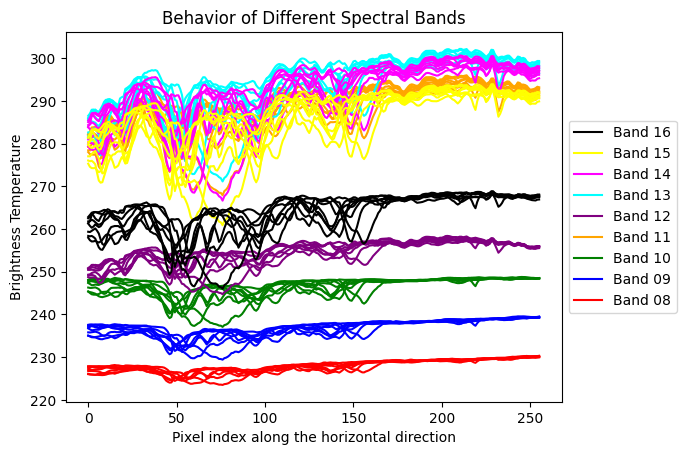

In [7]:
bands = ['08', '09', '10', '11', '12', '13', '14', '15', '16']
colours = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black']

train_files=[]
dataset = r'Z:\google research'
train = os.path.join(dataset, 'train')
for im in os.listdir(train):
    train_files.append(os.path.join(train,im))
scene = train_files[1]

sc_band08=np.load(os.path.join(scene,'band_08.npy'))
sc_band09=np.load(os.path.join(scene,'band_09.npy'))
sc_band10=np.load(os.path.join(scene,'band_10.npy'))
sc_band11=np.load(os.path.join(scene,'band_11.npy'))
sc_band12=np.load(os.path.join(scene,'band_12.npy'))
sc_band13=np.load(os.path.join(scene,'band_13.npy'))
sc_band14=np.load(os.path.join(scene,'band_14.npy'))
sc_band15=np.load(os.path.join(scene,'band_15.npy'))
sc_band16=np.load(os.path.join(scene,'band_16.npy'))

name_bands=[]
legend_handles = []
for index, band in enumerate(bands):

    sc_band = locals()[f'sc_band{band}']
    name_bands.append(f'sc_band{band}')
    
    colour = colours[index]
    plt.plot(sc_band[4], color=colour, label=f'Band {band}')
    legend_handles.append(Line2D([0], [0], color=colour, label=f'Band {band}'))

legend_handles.reverse()
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Pixel index along the horizontal direction')
plt.ylabel('Brightness Temperature')
plt.title('Behavior of Different Spectral Bands')
plt.show()

We calculate the mean and variance of the different bands in the validation set to later standardize the values

In [41]:

def image_stardization_data(set_name, range):
     band11 = []
     band14 = []
     band15 = []
     count = 0

     start_time = time.time()
     total_scenes = math.floor(len(os.listdir(set_name))*range)

     for scene in (os.listdir(set_name)[:total_scenes]):

          try:
              
               sc_band11=np.load(os.path.join(set_name, scene,'band_11.npy'))
               sc_band14=np.load(os.path.join(set_name, scene,'band_14.npy'))
               sc_band15=np.load(os.path.join(set_name, scene,'band_15.npy'))

               band11.append(sc_band11[:,:,4])
               band14.append(sc_band14[:,:,4])
               band15.append(sc_band15[:,:,4])

               count += 1
               
               if count % 2 == 0:
                    time_spent = time.time() - start_time
                    scenes_left = total_scenes - count
                    ETA = time_spent/count*scenes_left
                    ETA_hours = int(np.floor(ETA / 3600))
                    ETA_minutes = int(np.floor((ETA - ETA_hours*3600)/60))
                    print(f'Estimated time left: {ETA_hours}hr:{ETA_minutes}min. Processed {count}/{total_scenes}', end='\r')

          except Exception as e:
               continue

     mu11 = np.mean(band11)
     mu14 = np.mean(band14)
     mu15 = np.mean(band15)
     mu = [mu11, mu14, mu15]
     sigma11 = np.var(band11)
     sigma14 = np.var(band14)
     sigma15 = np.var(band15)
     sigma = [sigma11, sigma14, sigma15]
     min11 = np.min(band11)
     min14 = np.min(band14)
     min15 = np.min(band15)
     mins = [min11, min14, min15]
     max11 = np.max(band11)
     max14 = np.max(band14)
     max15 = np.max(band15)
     maxs = [max11, max14, max15]

     return mu, sigma, mins, maxs

mu_val, sigma_val, mins, maxs = image_stardization_data(validation,0.1)

In [42]:
mu_11, mu_14, mu_15 = mu_val
sigma_11, sigma_14, sigma_15 = sigma_val
min_11, min_14, min_15 = mins
max_11, max_14, max_15 = maxs

mu_r = mu_15 - mu_14
mu_b = mu_14
mu_g = mu_14 - mu_11
sigma_r = sigma_15 - sigma_14
sigma_b = sigma_14
sigma_g = sigma_14 - sigma_11
min_r = min_15 - max_14
min_b = min_14
min_g = min_14 - max_11
max_r = max_15 - min_14
max_b = max_14
max_g = max_14 - min_11

print(f'For red color, the mean is {mu_r: .2f} and the variance is {sigma_r: .2f}, the minimum value is {min_r: .2f} and the maximum {max_r: .2f}')
print(f'For blue color, the mean is {mu_b: .2f} and the variance is {sigma_b: .2f}, the minimum value is {min_b: .2f} and the maximum {max_b: .2f}')
print(f'For green color, the mean is {mu_g: .2f} and the variance is {sigma_g: .2f}, the minimum value is {min_g: .2f} and the maximum {max_g: .2f}')

For red color, the mean is -2.83 and the variance is -22.66, the minimum value is -142.20 and the maximum  137.92
For blue color, the mean is  274.01 and the variance is  432.56, the minimum value is  181.89 and the maximum  323.25
For green color, the mean is  0.63 and the variance is  55.07, the minimum value is -134.57 and the maximum  140.39


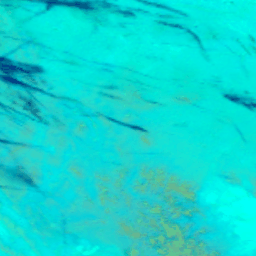

In [8]:
# Normalizes a matrix or a tensor to a given range of values
# In the words of the original paper "Each input channel is standardized by subtracting the global mean and dividing by the global variance of the channel before feeding it into the network."
# so it may be worth trying their solution too for the training"
def normalization(data, range):
    return (data - range[0]) / (range[1]-range[0])

def standardization(data, mean, variance):
    return (data - mean)/variance

# Creates the ash-composite given the bands 11, 14 and 15 of a sequence of images. The bands have size (256,256,8). The output is a tensor of size (256, 256, 3, 8)
def ash_sequence(b11,b14,b15):
    r_range=[-4,2]         
    b_range= [243,303]
    g_range=[-4,5]          

    r=normalization(b15-b14, r_range)          
    b=normalization(b14, b_range)               
    g=normalization(b14-b11, g_range)         
    ash=np.clip(np.stack([r,g,b],axis=2),0,1)
    return ash

# Returns the 5th ash-composite image of size (256, 256, 3) corresponding to the labelled image
def ash_image(ash):
    image = (ash[:,:,:,4] * 255).astype(np.uint8)
    return image

# Returns the 8 ash-composite images of size (256, 256, 3) of a given sequence
def ash_images(ash,start,stop):
    images=[]
    for i in range(start,stop):
        im=(ash[:,:,:,i] * 255).astype(np.uint8)
        images.append(Image.fromarray(im))
    return images

# Creates a GIF with the ash-composite images
def gif_ash(ash_images, w, h):
    gif_bytes = io.BytesIO()
    ash_images[0].save(gif_bytes, format='GIF', save_all=True, append_images=ash_images[1:], duration=1000, loop=0)
    return display(IPImage(data=gif_bytes.getvalue(), format='png', width=w, height=h))


images1=ash_images(ash_sequence(sc_band11,sc_band14,sc_band15),0,8)
gif_ash(images1,256,256)


### 3.2. Binary labels

An example of the labelling given by the different labellers for a train image. I also added the case of the union of all labellers (soft labelling).

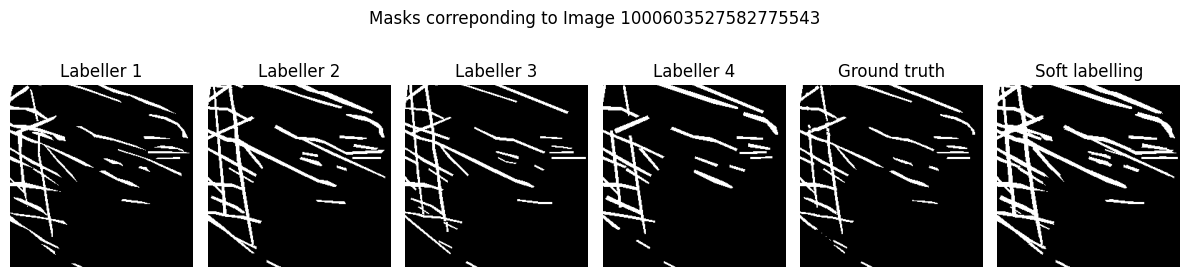

In [13]:
def visualize_masks(dict_mask, labellers):   
    fig, axes = plt.subplots(1, labellers+2, figsize=(12, 3))

    for labeller in range(labellers):
        axes[labeller].imshow(dict_mask[f'mask_{labeller+1}'], cmap='gray')
        axes[labeller].set_title(f'Labeller {labeller+1}')
        axes[labeller].axis("off")

    axes[labeller+1].imshow(dict_mask['ground_truth'], cmap='gray')
    axes[labeller+1].set_title(f'Ground truth')
    axes[labeller+1].axis("off")

    axes[labeller+2].imshow(dict_mask['soft_labels'], cmap='gray')
    axes[labeller+2].set_title(f'Soft labelling')
    axes[labeller+2].axis("off")

    name=os.path.split(scene)[-1]
    plt.suptitle(f'Masks correponding to Image {name}', y=1)
    plt.tight_layout()
    return plt.show()


dataset = r'Z:\google research'
train = os.path.join(dataset, 'train')
train_files=[]
for im in os.listdir(train):
    train_files.append(os.path.join(train,im))

scene = train_files[1]
sc_human_individual_labels=np.load(os.path.join(scene,'human_individual_masks.npy'))
sc_ground_truth=np.load(os.path.join(scene,'human_pixel_masks.npy'))

labels={}

labellers = sc_human_individual_labels.shape[3]
for i in range(labellers):
    labels[f"mask_{i+1}"]=sc_human_individual_labels[:, :, 0, i]
labels["ground_truth"]=sc_ground_truth[:,:,0]

# Calculate union of all masks
soft_labels = np.any(sc_human_individual_labels, axis=3)
labels["soft_labels"]=soft_labels

visualize_masks(labels, labellers)

## 4. Conversion for training

### 4.1. PNG conversion (single image)

First, the origin of the files is specified

In [16]:
dataset = r'Z:\google research'
train = os.path.join(dataset, 'train')
test = os.path.join(dataset, 'test')
validation = os.path.join(dataset, 'validation')

The destination folder is then specified

In [17]:
# specify the destination directories
destination = r'D:\GOES-16 Dataset\SingleFrame_PNG'

train_images = os.path.join(destination, 'train', 'images')
os.makedirs(train_images, exist_ok=True)
test_images = os.path.join(destination, 'test', 'images')
os.makedirs(test_images, exist_ok=True)
validation_images = os.path.join(destination, 'validation', 'images')
os.makedirs(validation_images, exist_ok=True)

train_gt = os.path.join(destination, 'train', 'ground_truth')
os.makedirs(train_gt, exist_ok=True)
test_gt = os.path.join(destination, 'test', 'ground_truth')
os.makedirs(test_gt, exist_ok=True)
validation_gt = os.path.join(destination, 'validation', 'ground_truth')
os.makedirs(validation_gt, exist_ok=True)

train_sl = os.path.join(destination, 'train', 'soft_label')
os.makedirs(train_sl, exist_ok=True)
test_sl = os.path.join(destination, 'test', 'soft_label')
os.makedirs(test_sl, exist_ok=True)
validation_sl = os.path.join(destination, 'validation', 'soft_label')
os.makedirs(validation_sl, exist_ok=True)

Note that another possibility is to train only on positive examples, for which we would need to first detect the positive images

In [6]:

def positives_counter(files, path, set_name):
     positives=0
     negatives=0
     positive_examples=[]
     negative_examples=[]

     not_accessed=0
     count = 0

     start_time = time.time()
     total_scenes = len(files)

     print(f"Examining files of {set_name} set...")
     for image in files:
          count+=1
          try:
               im=np.load(os.path.join(str(image),'human_pixel_masks.npy'))
               if len(np.unique(im))>1:
                    positives+=1
                    positive_examples.append(image)
               else:
                    negatives+=1
                    negative_examples.append(image)
          except:
               not_accessed+=1

          time_spent = time.time() - start_time
          scenes_left = total_scenes - count
          ETA = time_spent/count*scenes_left
          ETA_hours = int(np.floor(ETA / 3600))
          ETA_minutes = int(np.floor((ETA - ETA_hours*3600)/60))
          print(f'Estimated time left: {ETA_hours}hr:{ETA_minutes}min. Examined {count} files.', end="\r")
          
     print(f'There are {positives}/{total_scenes} files in the {set_name} set containing at least one contrail')
     print(f'There are {not_accessed} not accessed files in the {set_name} set')
     np.save(f'{path}/positive_{set_name}.npy',positive_examples)


path_to_save = r'C:\Users\USER\Desktop\UNIVERSIDAD\MÁSTER AERONÁUTICA - UC3M\SEGUNDO\TRABAJO DE FIN DE MÁSTER\Development\contrails_detection_Jesus\Inspection'
sets = [['train',train_files], ['validation',val_files]]

for idx, set in enumerate(sets):
     positives_counter(set[1], path_to_save, set[0])

Examining files of train set...
There are 9259/20529 files in the train set containing at least one contrail
There are 0 not accessed files in the train set
Examining files of validation set...
There are 552/1857 files in the validation set containing at least one contrail
There are 1 not accessed files in the validation set


Finally, the arrays are converted into images and saved in the directory.

In [39]:
sets=[[train,validation,test],[train_images,validation_images,test_images],[train_gt,validation_gt,test_gt],[train_sl,validation_sl,test_sl]]

def image_processor(sets, image_generation=True, soft_label=False):

    for i in range(len(sets[0])):
        count=0

        set=sets[0][i]

        if i == 0:
            set_name = 'training'
        elif i == 1:
            set_name = 'validation'
        elif i == 2:
            set_name = 'testing'

        start_time = time.time()
        total_scenes = len(os.listdir(set))

        print(f"\n Copying data of {set_name} set... \n")

        for image in (os.listdir(set)):
            path=os.path.join(set,image)
            try:
                if image_generation:
                    band11=np.load(os.path.join(path,'band_11.npy'))
                    band14=np.load(os.path.join(path,'band_14.npy'))
                    band15=np.load(os.path.join(path,'band_15.npy'))
                    image_path=os.path.join(sets[1][i],f'{image}.png')
                    sequence=ash_sequence(band11,band14,band15)
                    image_ash =ash_images(sequence,0,8)[4]
                    imageio.imwrite(image_path,image_ash)

                if set_name != 'testing':
                    if soft_label:
                        individual_label_masks=np.load(os.path.join(path,'human_individual_masks.npy'))
                        soft_label_array=np.any(individual_label_masks, axis=3).astype(int)
                        soft_label_path=os.path.join(sets[3][i],f'{image}.npy')
                        np.save(soft_label_path,soft_label_array)
                    else:
                        human_pixel_masks=np.load(os.path.join(path,'human_pixel_masks.npy'))
                        ground_truth_path=os.path.join(sets[2][i],f'{image}.npy')
                        np.save(ground_truth_path,human_pixel_masks)
                
                count+=1
                time_spent = time.time() - start_time
                scenes_left = total_scenes - count
                ETA = time_spent/count*scenes_left
                ETA_hours = int(np.floor(ETA / 3600))
                ETA_minutes = int(np.floor((ETA - ETA_hours*3600)/60))
                print(f'Estimated time left: {ETA_hours}hr:{ETA_minutes}min. Processed {count}/{total_scenes} within the {set_name} set', end='\r')
            
            except Exception as e:
                print(e)
                continue 

    return True

image_processor(sets, image_generation=False, soft_label=True)


 Copying data of training set... 

Estimated time left: 0hr:0min. Processed 20529/20529 within the training sett
 Copying data of validation set... 

[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1000834164244036115\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1002653297254493116\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1002777035567823518\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1010397530434035516\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1012978360687713914\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1013721207578258217\\human_individual_masks.npy'
[Errno 2] No such file or directory: 'Z:\\google research\\validation\\1024187583264624816\\human_individual_masks.npy'
[Errno 2]

True

If several frames need to be saved, the following code can be used

In [ ]:
import tifffile

sets=[[train,validation, test],[train_images,validation_images,test_images],[train_gt,validation_gt, test_gt]]

def ash_images_TIF(ash,start,stop):
    images=[]
    stacked = []
    for i in range(start,stop):                   # Can be reduced to several specific frames
          im=(ash[:,:,:,i] * 255).astype(np.uint8)
          images.append(im)
    stacked = np.stack(images,axis=0)
    return stacked

def TIF_processor(sets):
     for i in range(len(sets[0])):
        count=0

        set=sets[0][i]

        if i == 0:
            set_name = 'training'
        elif i == 1:
            set_name = 'validation'
        elif i == 2:
            set_name = 'testing'

        start_time = time.time()
        total_scenes = len(os.listdir(set))

        print(f"Copying images of {set_name} set...", end="\n")

        for image in (os.listdir(set)):
            try:
                path=os.path.join(set,image)
                band11=np.load(os.path.join(path,'band_11.npy'))
                band14=np.load(os.path.join(path,'band_14.npy'))
                band15=np.load(os.path.join(path,'band_15.npy'))
                image_path=os.path.join(sets[1][i],f'{image}')
                sequence=ash_sequence(band11,band14,band15)
                image_ash =ash_images_TIF(sequence,0,8)
                tifffile.imwrite(image_path + '.tif', image_ash)

                if set_name != 'testing':
                    human_pixel_masks=np.load(os.path.join(path,'human_pixel_masks.npy'))
                    ground_truth_path=os.path.join(sets[2][i],f'{image}.npy')
                    np.save(ground_truth_path,human_pixel_masks)
                
                count+=1
                time_spent = time.time() - start_time
                scenes_left = total_scenes - count
                ETA = time_spent/count*scenes_left
                ETA_hours = int(np.floor(ETA / 3600))
                ETA_minutes = int(np.floor((ETA - ETA_hours*3600)/60))
                print(f'Estimated time left: {ETA_hours}hr:{ETA_minutes}min. Processed {count}/{total_scenes} within the {set_name} set.', end='\r')
                    
            except Exception as e:
                continue 

TIF_processor(sets)